In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

In [2]:
from __future__ import annotations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images[:7000]
test_images = test_images[:3000]
train_labels = train_labels[:7000]
test_labels = test_labels[:3000]

train_images = train_images.reshape((7000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((3000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
class Individual:
    def __init__(self, generation: int=0) -> None:
        self.generation = generation
        self.gene = [0 if np.random.random() < 0.5 else 1 for _ in range(17)]
        self.eval = 0
        self.metrics = {}

    def _evaluate(self, X_train, X_test, y_train, y_test) -> None:
        self.model = keras.Sequential()
        self.model.add(layers.Conv2D(2 ** (int("".join(map(str, self.gene[2:4])), 2) + 4), (3, 3), activation='relu', input_shape=(28, 28, 1)))
        self.model.add(layers.MaxPooling2D((2, 2)))
        for i in range(1, int("".join(map(str, self.gene[0:2])), 2)):
            self.model.add(layers.Conv2D(2 ** (int("".join(map(str, self.gene[2:4])), 2) + 4), (3, 3), activation="relu"))
            if (i % 2) != 0:
                self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Flatten())
        for _ in range(int("".join(map(str, self.gene[4:6])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[6:12])), 2) + 1, activation="relu"))
        self.model.add(layers.Dense(10, activation='softmax'))

        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2, verbose=False)
        weights = self.model.get_weights()
        loss, accuracy = self.model.evaluate(test_images, test_labels, verbose=False)
        self.metrics["loss"] = (1, loss)
        self.metrics["accuracy"] = (-1, accuracy)
        self.metrics["weights_norm"]= (1, sum([np.linalg.norm(w) for w in weights]))
        start = time()
        y_pred = self.model.predict(test_images, verbose=False)
        end = time()
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(test_labels, axis=1)
        self.metrics["f1_score"] = (-1, f1_score(y_test, y_pred, average="macro"))
        self.metrics["latency"] = (1, (end - start) / 3000)


    def crossover(self, other_individual: Individual) -> list[Individual]:
        cut = round(np.random.rand() * len(self.gene))
        child1 = other_individual.gene[0:cut] + self.gene[cut::]
        child2 = self.gene[0:cut] + other_individual.gene[cut::]

        children = [Individual(self.generation + 1), Individual(self.generation + 1)]

        children[0].gene = child1
        children[1].gene = child2

        return children

    def mutation(self, mutation_rate: float) -> Individual:
        for i in range(len(self.gene)):
            if np.random.random() < mutation_rate:
                if self.gene[i]:
                    self.gene[i] = 0
                else:
                    self.gene[i] = 1
        return self

    def __repr__(self):
        return f"""Generation: {self.generation}
Gene: {self.gene}
{int("".join(map(str, self.gene[0:2])), 2) + 1} camadas convolucionais com {2 ** (int("".join(map(str, self.gene[2:4])), 2) + 4)} neurons
{int("".join(map(str, self.gene[4:6])), 2) + 1} camadas densas com {int("".join(map(str, self.gene[6:12])), 2) + 1} neurons
"""

In [5]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test, first_objective, frist_threshold, second_objective, second_threshold) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = None
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []
        self.frontier = []
        self.fo = first_objective
        self.fo_threshold = frist_threshold
        self.so = second_objective
        self.so_threshold = second_threshold

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.metrics[self.fo][0]*individual.metrics[self.fo][1], reverse=True)

    def best_individual(self, pareto) -> Individual:
        first_minimum = min(pareto, key=lambda x: x.metrics[self.fo][0]*x.metrics[self.fo][1])
        first_threshold = first_minimum.metrics[self.fo][1] * self.fo_threshold
        low_bound = first_minimum.metrics[self.fo][0]*first_minimum.metrics[self.fo][1] - first_threshold
        high_bound = first_minimum.metrics[self.fo][0]*first_minimum.metrics[self.fo][1] + first_threshold
        interval = [
            individual for individual in pareto if low_bound <= individual.metrics[self.fo][0]*individual.metrics[self.fo][1] <= high_bound
        ]
        second_minimum = min(interval, key=lambda x: x.metrics[self.so][0]*x.metrics[self.so][1])
        second_threshold = second_minimum.metrics[self.so][1] * self.so_threshold
        low_bound = second_minimum.metrics[self.so][0]*second_minimum.metrics[self.so][1] - second_threshold
        high_bound = second_minimum.metrics[self.so][0]*second_minimum.metrics[self.so][1] + second_threshold
        interval2 = [
            individual for individual in interval if low_bound <= individual.metrics[self.so][0]*individual.metrics[self.so][1] <= high_bound
        ]
        if len(interval2) == 1:
            return second_minimum
        else:
            return min(interval2, key=lambda x: x.metrics[self.fo][0]*x.metrics[self.fo][1])

    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.metrics["accuracy"][1]
        return sum

    def select_parent(self, size:int) -> int:
        return np.random.randint(size)

    def visualize_generation(self, best) -> None:
        print(f"Best Solution -> G{best.generation}:")
        print(f"{self.fo}: {round(best.metrics[self.fo][1], 5)}")
        print(f"{self.so}: {round(best.metrics[self.so][1], 5)}")
        print(f"Gene: {best.gene}")

    def pareto_result(self):
        frontier_fo = []
        frontier_so = []
        for individual in self.pareto_frontier:
            frontier_fo.append(individual.metrics[self.fo][0]*individual.metrics[self.fo][1])
            frontier_so.append(individual.metrics[self.so][0]*individual.metrics[self.so][1])
        pareto_fo = []
        pareto_so = []
        for individual in self.frontier:
            pareto_fo.append(individual.metrics[self.fo][0]*individual.metrics[self.fo][1])
            pareto_so.append(individual.metrics[self.so][0]*individual.metrics[self.so][1])
        self.best_solution = self.best_individual(self.pareto_frontier)
        plt.figure(figsize=(10,6), dpi=800)
        plt.plot(pareto_so, pareto_fo, color="blue", marker="*", linestyle="None", label="Dominated Solutions")
        plt.plot(frontier_so, frontier_fo, color="red", marker="*", linestyle="None", label="Non Dominated Solutions")
        plt.plot(
            self.best_solution.metrics[self.so][0]*self.best_solution.metrics[self.so][1],
            self.best_solution.metrics[self.fo][0]*self.best_solution.metrics[self.fo][1],
            color="green",
            marker="*",
            linestyle="None",
            label="Chosen Solution"
        )
        plt.xlabel(f"{self.so}")
        plt.ylabel(f"{self.fo}")
        plt.title(f"{self.fo} x {self.so}")
        plt.legend()

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for i in tqdm(range(len(self.population))):
            self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)


        for i in range(generations):
            for individual in self.population:
                frontier = not any(
                    (
                        individual.metrics[self.fo][0] * individual.metrics[self.fo][1] >
                        other_individual.metrics[self.fo][0] * other_individual.metrics[self.fo][1] and
                        individual.metrics[self.so][0] * individual.metrics[self.so][1] >
                        other_individual.metrics[self.so][0] * other_individual.metrics[self.so][1]
                    ) for other_individual in self.population
                )

                if frontier:
                    self.pareto.append(individual)
            self.frontier.append(self.pareto)
            new_population = []
            if len(self.pareto) == 1:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(self.population_size)

                    children = self.pareto[parent1].crossover(self.population[parent2])

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.pareto[0]
            else:
                for _ in range(0, self.population_size, 2):
                    parent1 = self.select_parent(len(self.pareto))
                    parent2 = self.select_parent(len(self.pareto))

                    children = self.pareto[parent1].crossover(self.pareto[parent2])

                    new_population.append(children[0].mutation(mutation_rate))
                    new_population.append(children[1].mutation(mutation_rate))
                    self.best_solution = self.best_individual(self.pareto)
            self.visualize_generation(self.best_solution)
            print(f"Generation {i + 1}")

            self.population = list(new_population)

            for i in tqdm(range(len(self.population))):
                self.population[i]._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)

        self.frontier = [item for row in self.frontier for item in row]

        self.pareto_frontier = []
        for individual in self.frontier:
            frontier = not any(
                (
                    individual.metrics[self.fo][0] * individual.metrics[self.fo][1] >
                    other_individual.metrics[self.fo][0] * other_individual.metrics[self.fo][1] and
                    individual.metrics[self.so][0] * individual.metrics[self.so][1] >
                    other_individual.metrics[self.so][0] * other_individual.metrics[self.so][1]
                ) for other_individual in self.frontier
            )

            if frontier:
                self.pareto_frontier.append(individual)
        self.pareto_result()

        return self.best_solution

Generation 0


100%|██████████| 12/12 [12:36<00:00, 63.04s/it]


G:0 ->  loss: 0.11 weights_norm: 39.61  Gene: [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 1


100%|██████████| 12/12 [13:43<00:00, 68.66s/it]


G:1 ->  loss: 0.12 weights_norm: 32.18  Gene: [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 2


100%|██████████| 12/12 [12:25<00:00, 62.10s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 3


100%|██████████| 12/12 [11:02<00:00, 55.21s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 4


100%|██████████| 12/12 [11:43<00:00, 58.61s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 5


100%|██████████| 12/12 [12:46<00:00, 63.89s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 6


100%|██████████| 12/12 [10:35<00:00, 52.93s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 7


100%|██████████| 12/12 [12:29<00:00, 62.44s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 8


100%|██████████| 12/12 [11:05<00:00, 55.48s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 9


100%|██████████| 12/12 [14:11<00:00, 70.94s/it]


G:2 ->  loss: 0.11 weights_norm: 27.49  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Generation 10


100%|██████████| 12/12 [10:52<00:00, 54.41s/it]


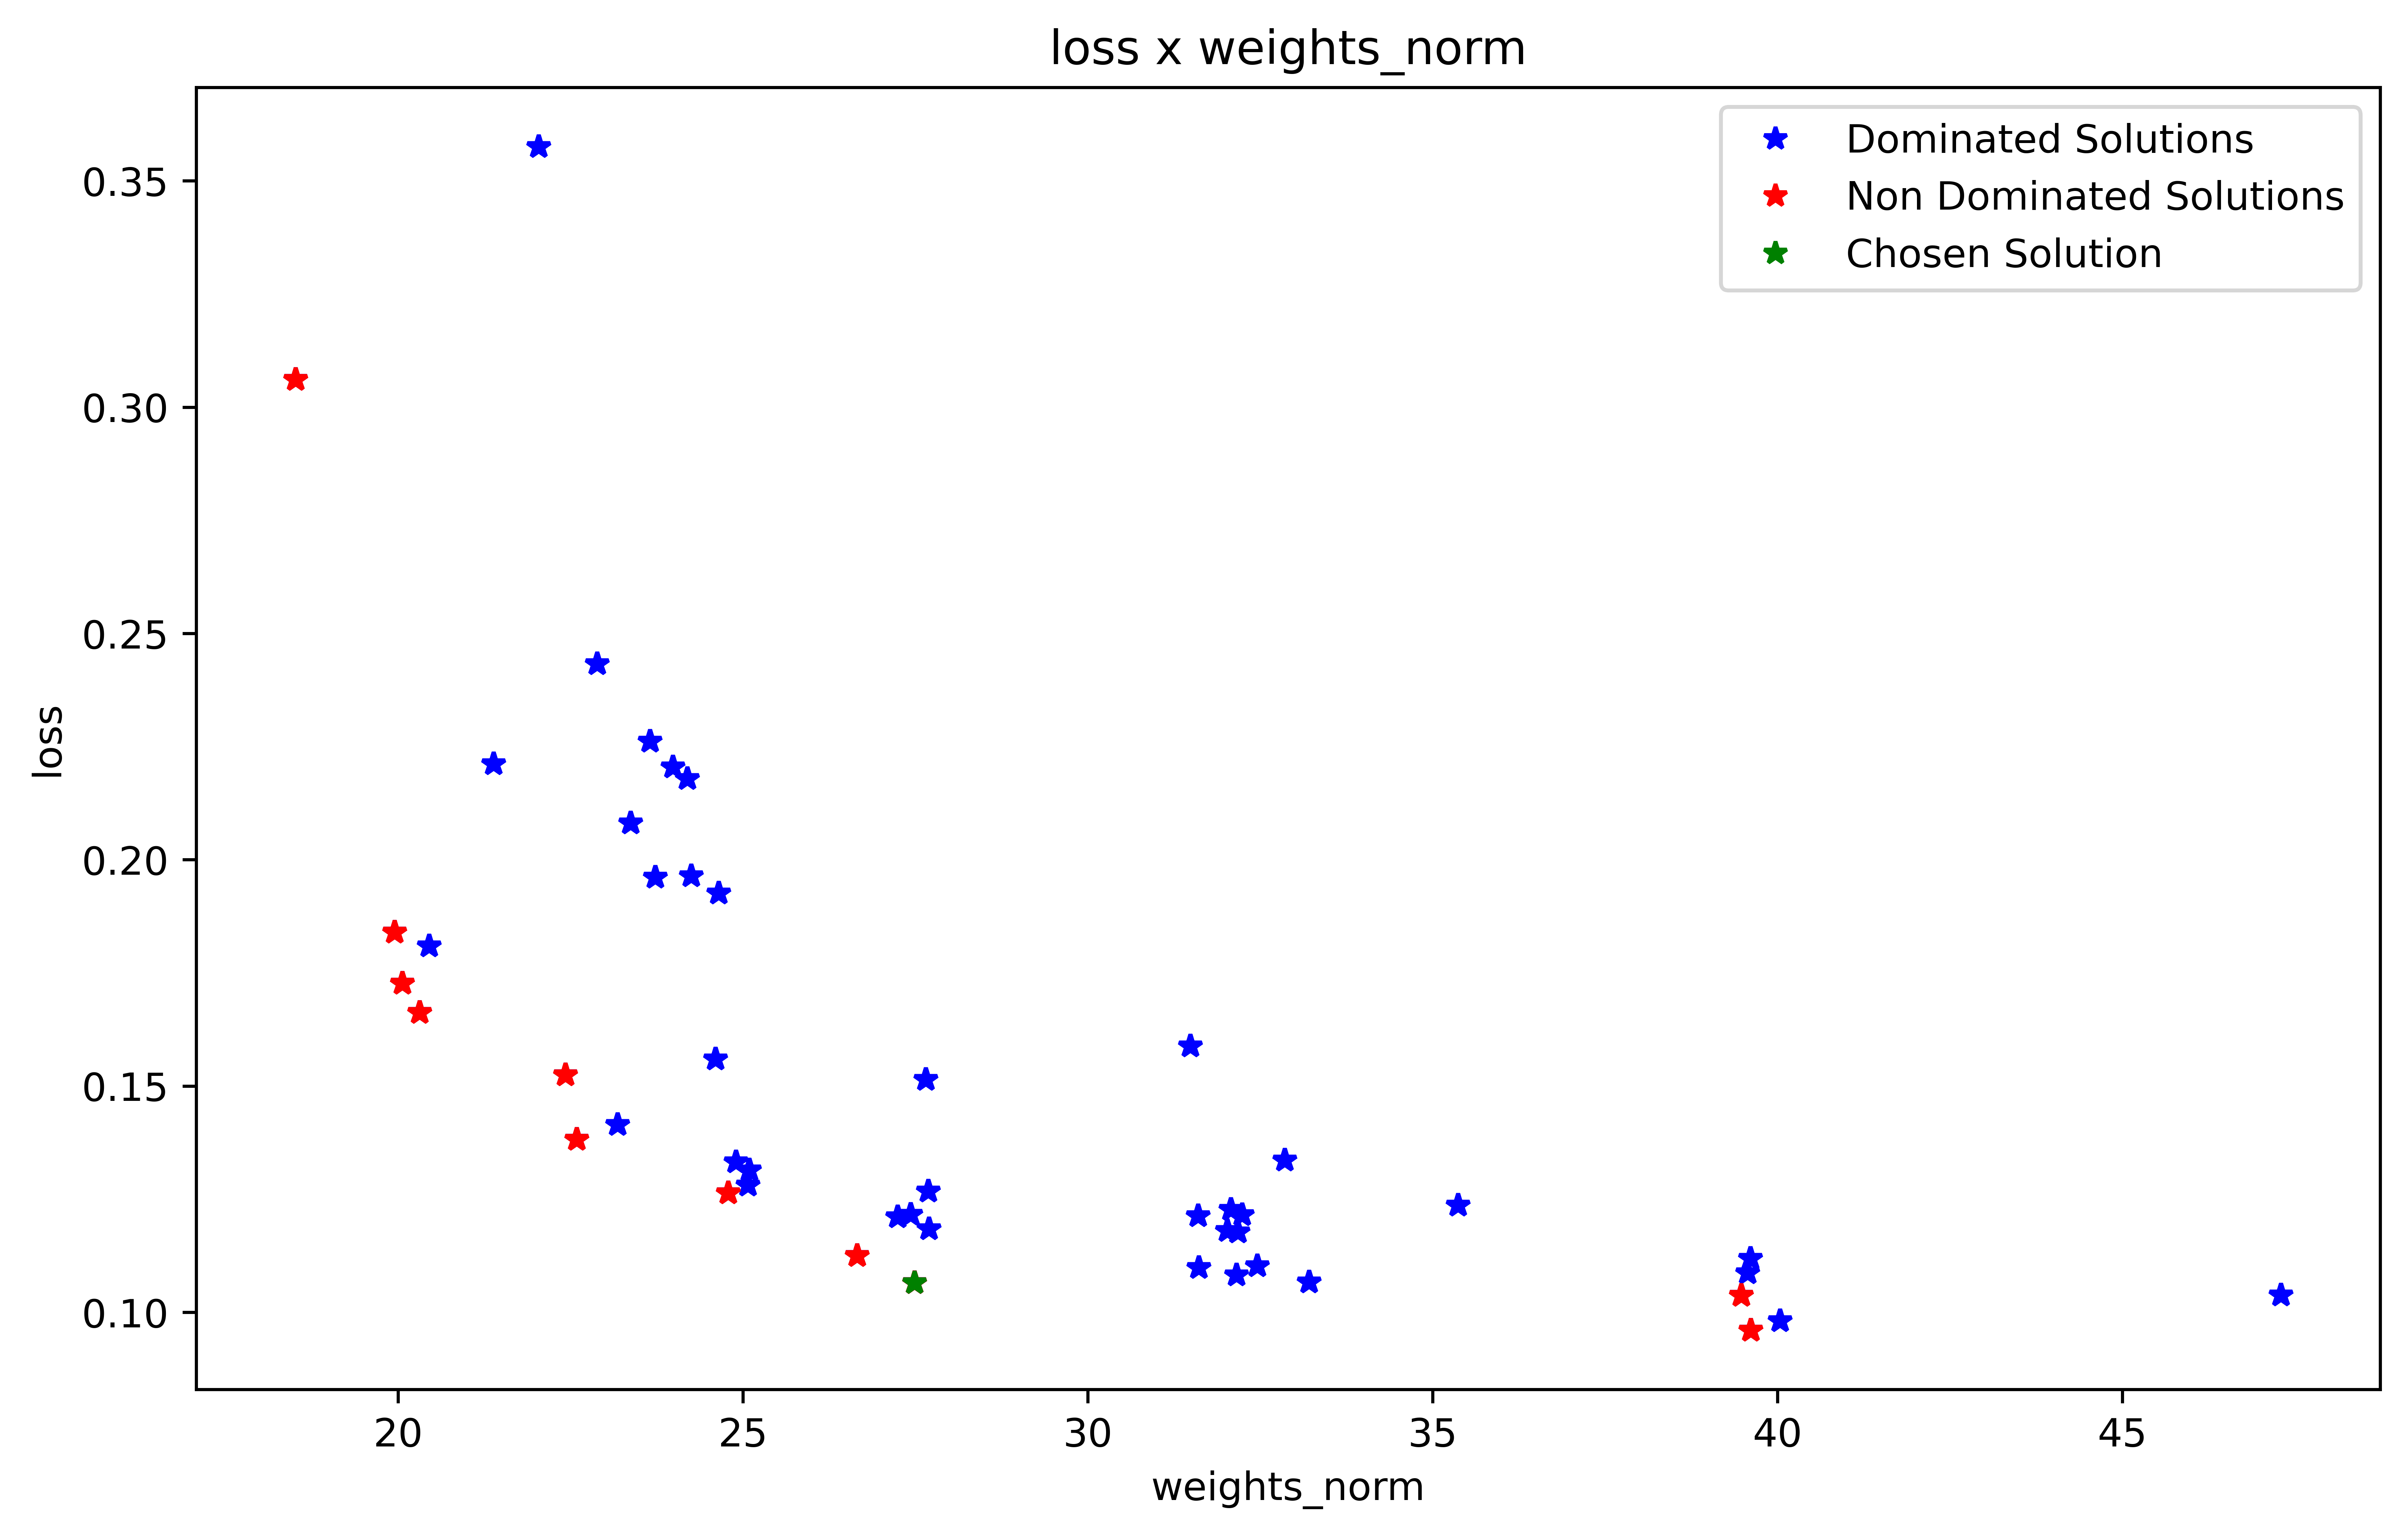

In [ ]:
ga = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "loss", 0.30, "weights_norm", 0.30)
result = ga.solve(generations=10)

Generation 0


100%|██████████| 12/12 [17:04<00:00, 85.37s/it]


G:0:
 accuracy: 0.95
 latency: 0.0
  Gene: [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Generation 1


100%|██████████| 12/12 [11:58<00:00, 59.86s/it]


G:0:
 accuracy: 0.95
 latency: 0.0
  Gene: [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Generation 2


100%|██████████| 12/12 [14:46<00:00, 73.85s/it] 


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 3


100%|██████████| 12/12 [09:38<00:00, 48.22s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 4


100%|██████████| 12/12 [11:32<00:00, 57.68s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 5


100%|██████████| 12/12 [10:38<00:00, 53.25s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 6


100%|██████████| 12/12 [12:18<00:00, 61.52s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 7


100%|██████████| 12/12 [08:42<00:00, 43.50s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 8


100%|██████████| 12/12 [09:16<00:00, 46.37s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 9


100%|██████████| 12/12 [09:56<00:00, 49.69s/it]


G:2:
 accuracy: 0.97
 latency: 0.0
  Gene: [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Generation 10


100%|██████████| 12/12 [10:32<00:00, 52.70s/it]


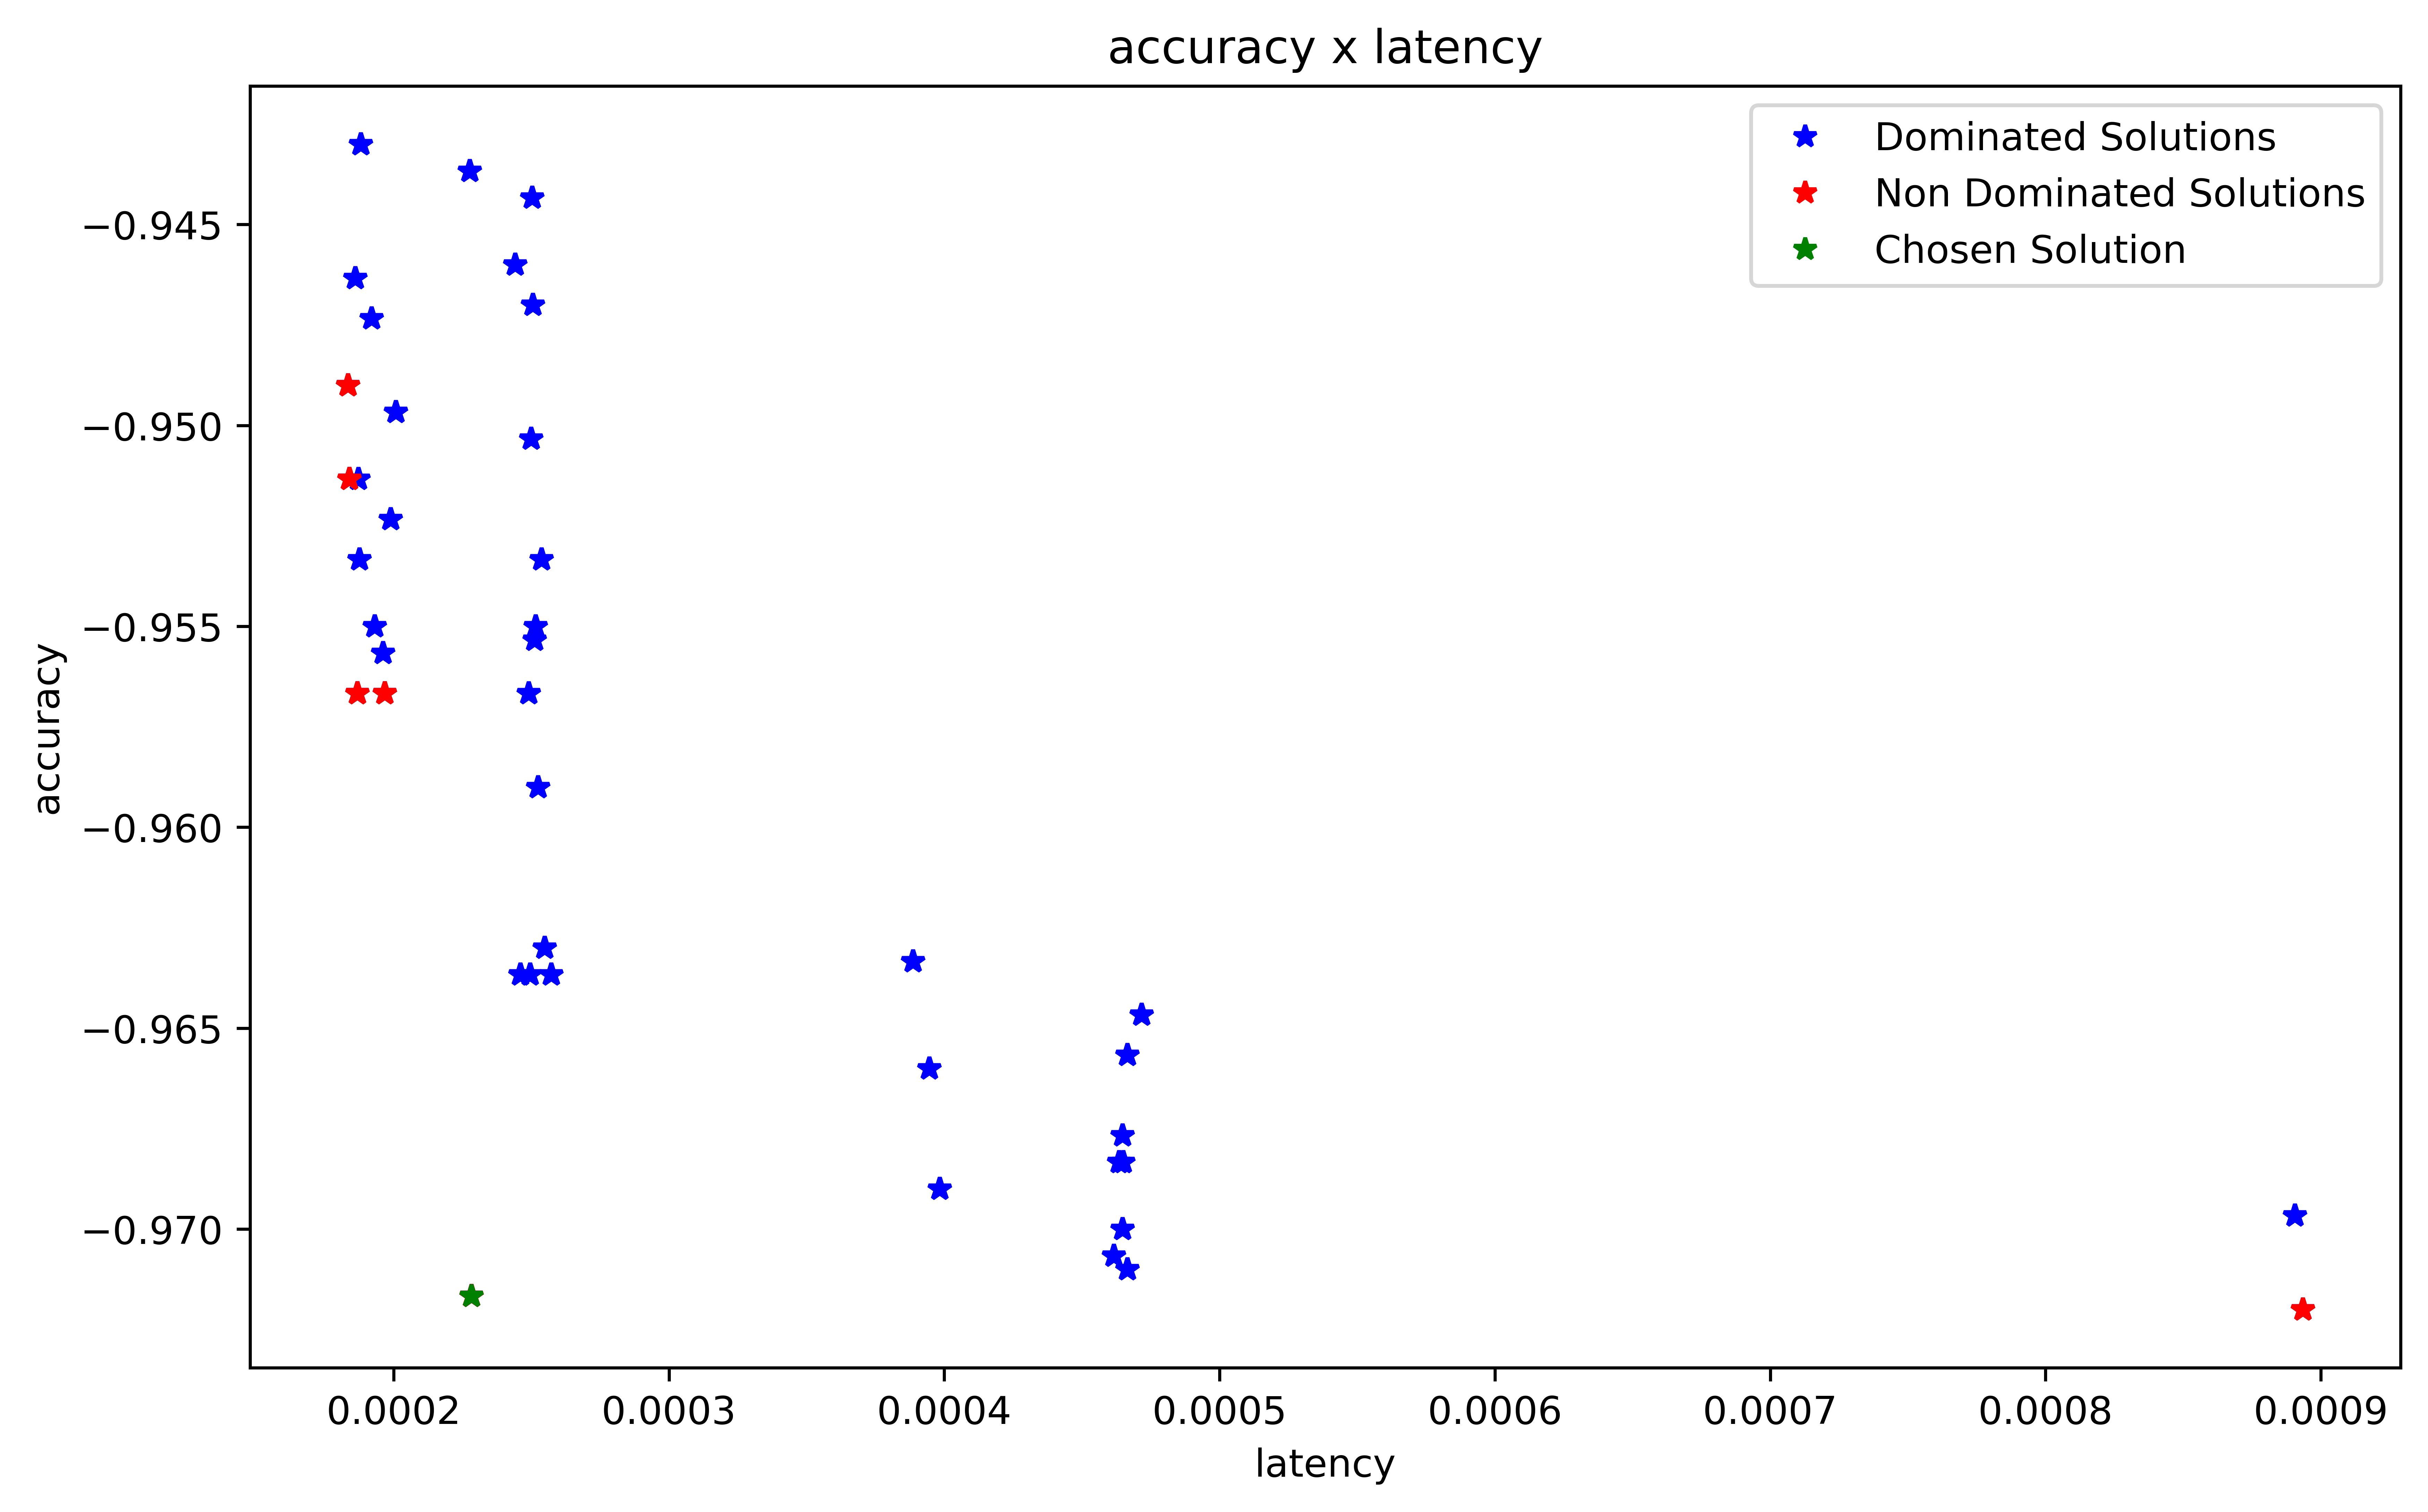

In [ ]:
ga1 = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "accuracy", 0.05, "latency", 0.30)
result = ga1.solve(generations=10)

Generation 0


100%|██████████| 12/12 [10:28<00:00, 52.38s/it]


Best Solution -> G:0:
 loss: 0.17537
 latency: 0.00025
  Gene: [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Generation 1


100%|██████████| 12/12 [07:41<00:00, 38.50s/it]


Best Solution -> G:1:
 loss: 0.09927
 latency: 0.00047
  Gene: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 2


100%|██████████| 12/12 [08:08<00:00, 40.70s/it]


Best Solution -> G:1:
 loss: 0.09927
 latency: 0.00047
  Gene: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 3


100%|██████████| 12/12 [10:29<00:00, 52.45s/it]


Best Solution -> G:1:
 loss: 0.09927
 latency: 0.00047
  Gene: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 4


100%|██████████| 12/12 [07:53<00:00, 39.42s/it]


Best Solution -> G:3:
 loss: 0.12499
 latency: 0.00017
  Gene: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Generation 5


100%|██████████| 12/12 [09:44<00:00, 48.67s/it]


Best Solution -> G:3:
 loss: 0.12499
 latency: 0.00017
  Gene: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Generation 6


100%|██████████| 12/12 [06:55<00:00, 34.66s/it]


Best Solution -> G:3:
 loss: 0.11887
 latency: 0.00021
  Gene: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Generation 7


100%|██████████| 12/12 [07:19<00:00, 36.64s/it]


Best Solution -> G:3:
 loss: 0.11887
 latency: 0.00021
  Gene: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Generation 8


100%|██████████| 12/12 [10:05<00:00, 50.45s/it]


Best Solution -> G:3:
 loss: 0.11887
 latency: 0.00021
  Gene: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Generation 9


100%|██████████| 12/12 [10:29<00:00, 52.48s/it]


Best Solution -> G:3:
 loss: 0.11887
 latency: 0.00021
  Gene: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Generation 10


100%|██████████| 12/12 [10:28<00:00, 52.36s/it]


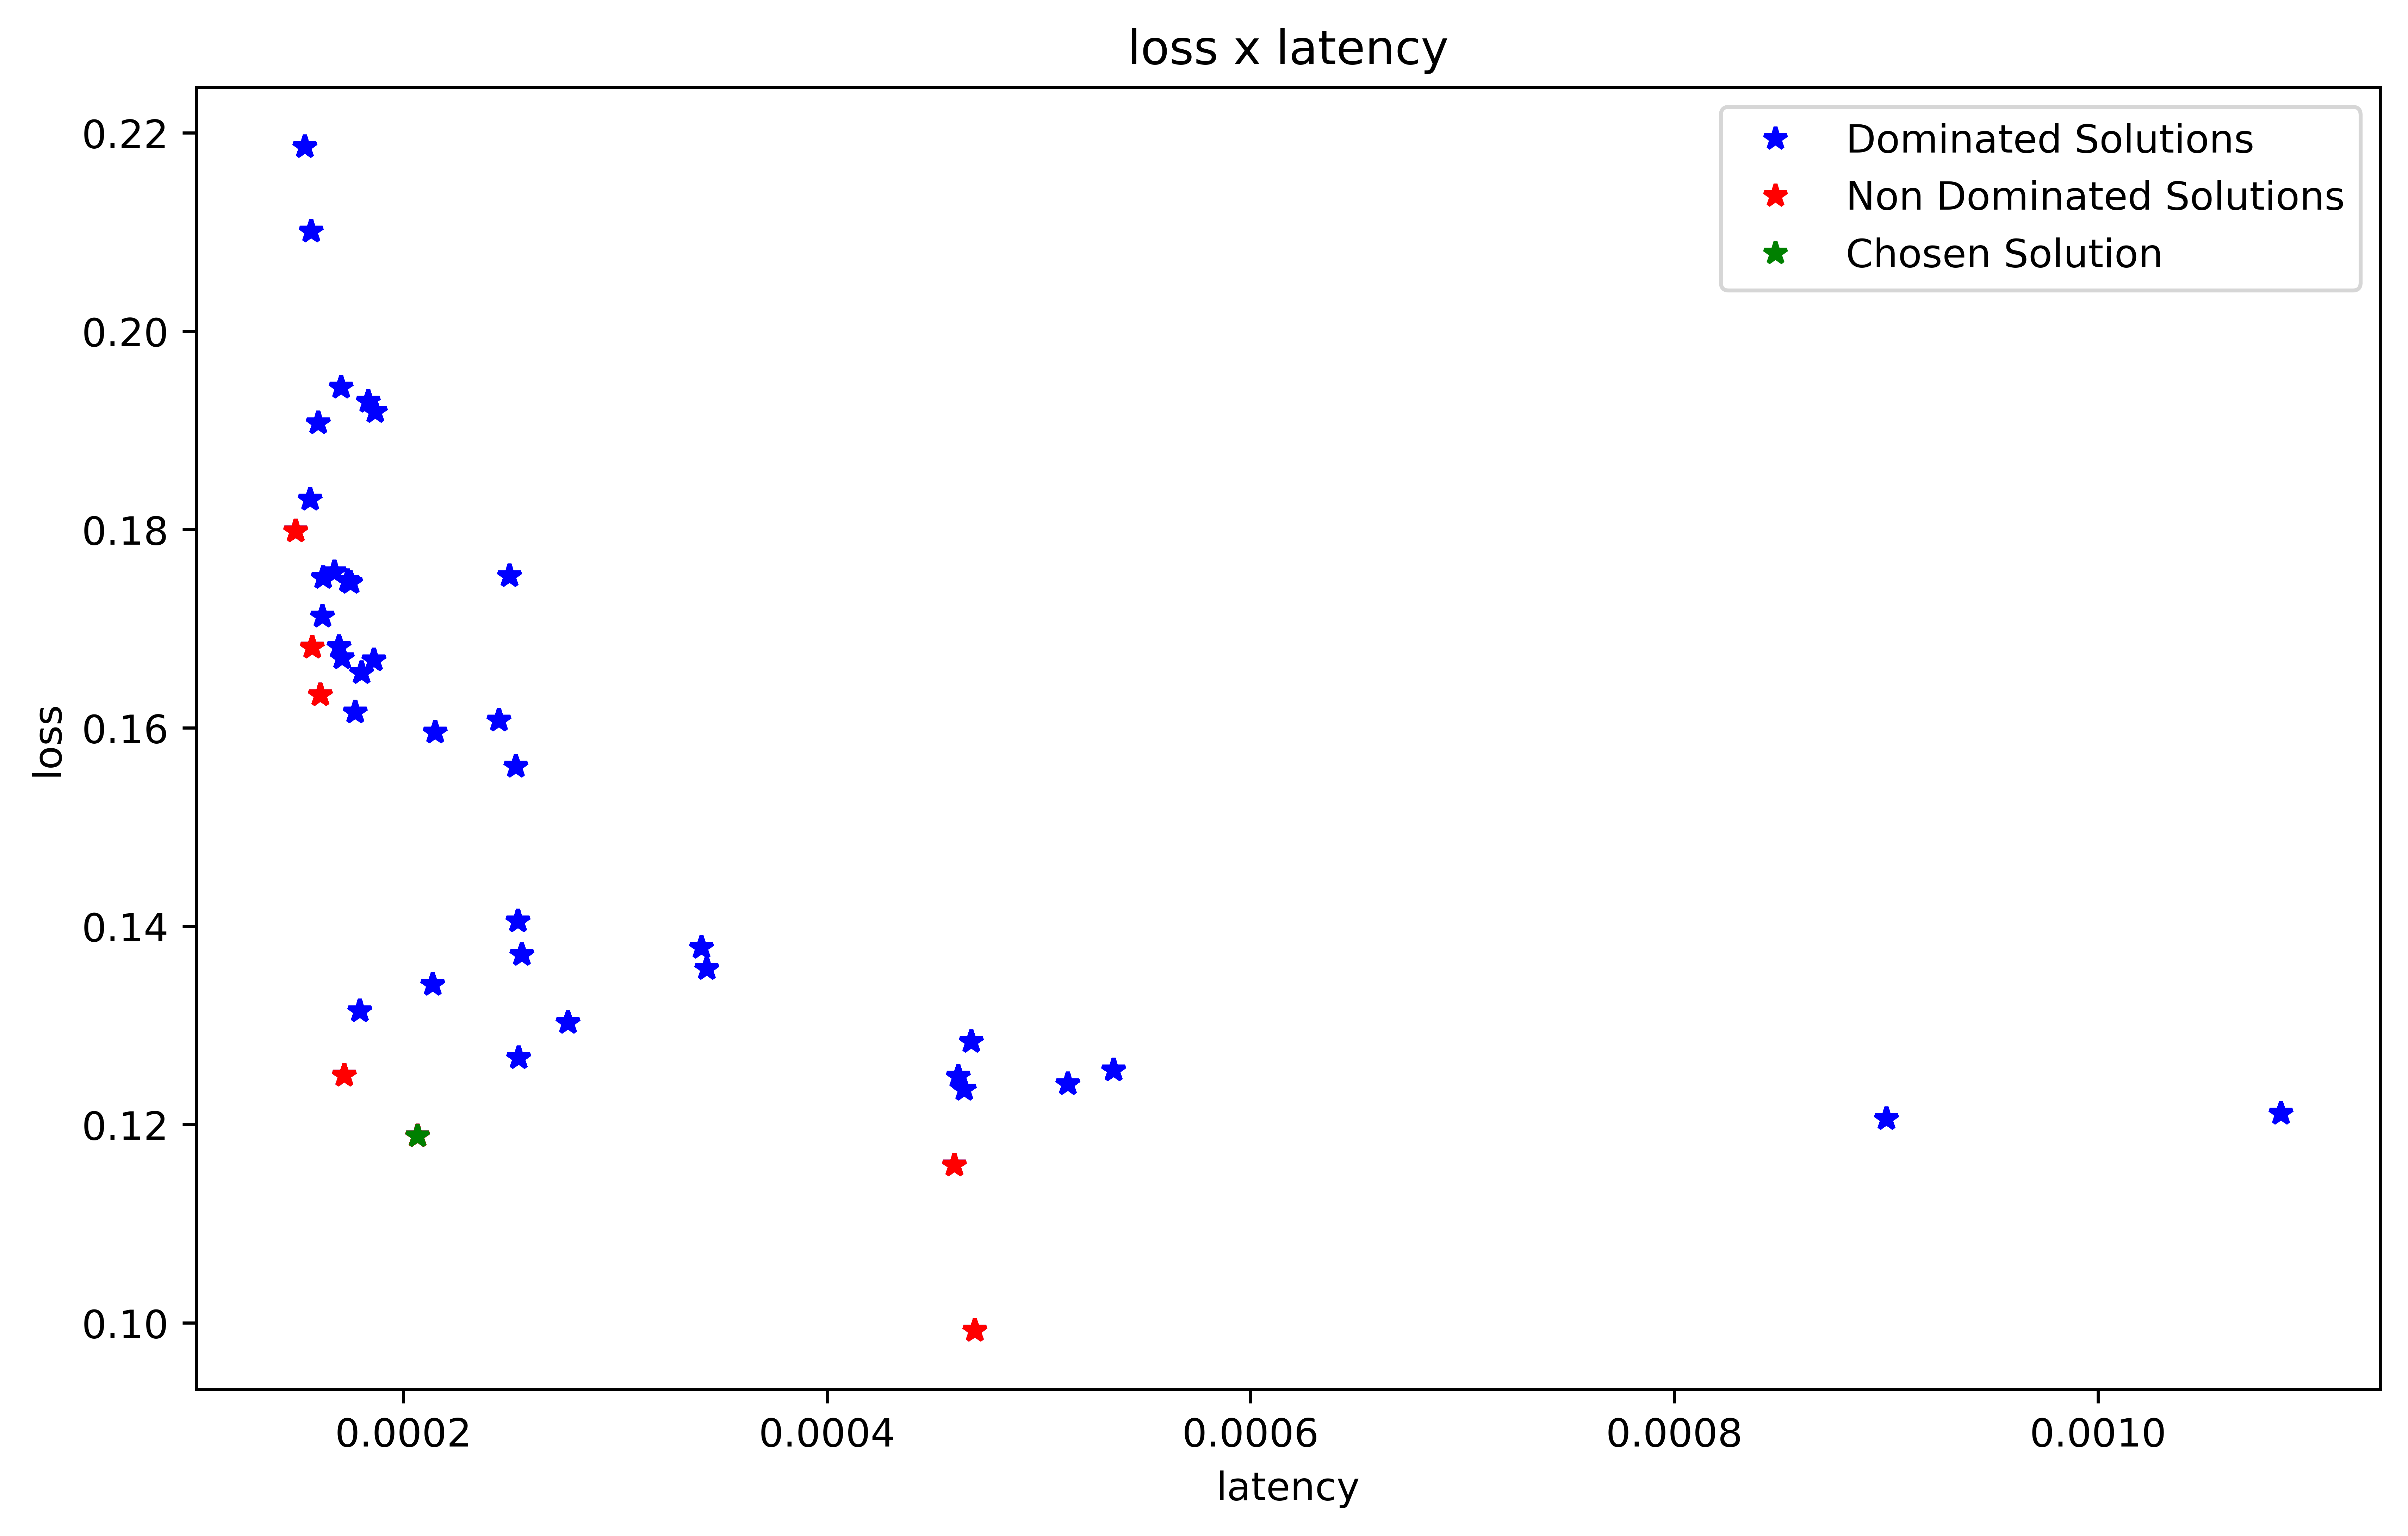

In [ ]:
ga2 = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "loss", 0.30, "latency", 0.30)
result = ga2.solve(generations=10)

Generation 0


100%|██████████| 12/12 [09:24<00:00, 47.04s/it]


Best Solution -> G:0:
 weights_norm: 16.63007
 loss: 0.36924
  Gene: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Generation 1


100%|██████████| 12/12 [05:20<00:00, 26.71s/it]


Best Solution -> G:1:
 weights_norm: 18.92552
 loss: 0.21429
  Gene: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Generation 2


100%|██████████| 12/12 [05:06<00:00, 25.57s/it]


Best Solution -> G:1:
 weights_norm: 11.37292
 loss: 1.9242
  Gene: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 3


100%|██████████| 12/12 [04:48<00:00, 24.07s/it]


Best Solution -> G:1:
 weights_norm: 11.37292
 loss: 1.9242
  Gene: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 4


100%|██████████| 12/12 [05:55<00:00, 29.65s/it]


Best Solution -> G:1:
 weights_norm: 11.37292
 loss: 1.9242
  Gene: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 5


100%|██████████| 12/12 [04:40<00:00, 23.37s/it]


Best Solution -> G:3:
 weights_norm: 4.64279
 loss: 2.30194
  Gene: [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 6


100%|██████████| 12/12 [10:34<00:00, 52.85s/it]


Best Solution -> G:3:
 weights_norm: 4.64279
 loss: 2.30194
  Gene: [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 7


100%|██████████| 12/12 [05:42<00:00, 28.57s/it]


Best Solution -> G:3:
 weights_norm: 4.46949
 loss: 2.30194
  Gene: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 8


100%|██████████| 12/12 [04:59<00:00, 24.98s/it]


Best Solution -> G:3:
 weights_norm: 4.46949
 loss: 2.30194
  Gene: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 9


100%|██████████| 12/12 [05:52<00:00, 29.36s/it]


Best Solution -> G:3:
 weights_norm: 4.46949
 loss: 2.30194
  Gene: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generation 10


100%|██████████| 12/12 [05:39<00:00, 28.26s/it]


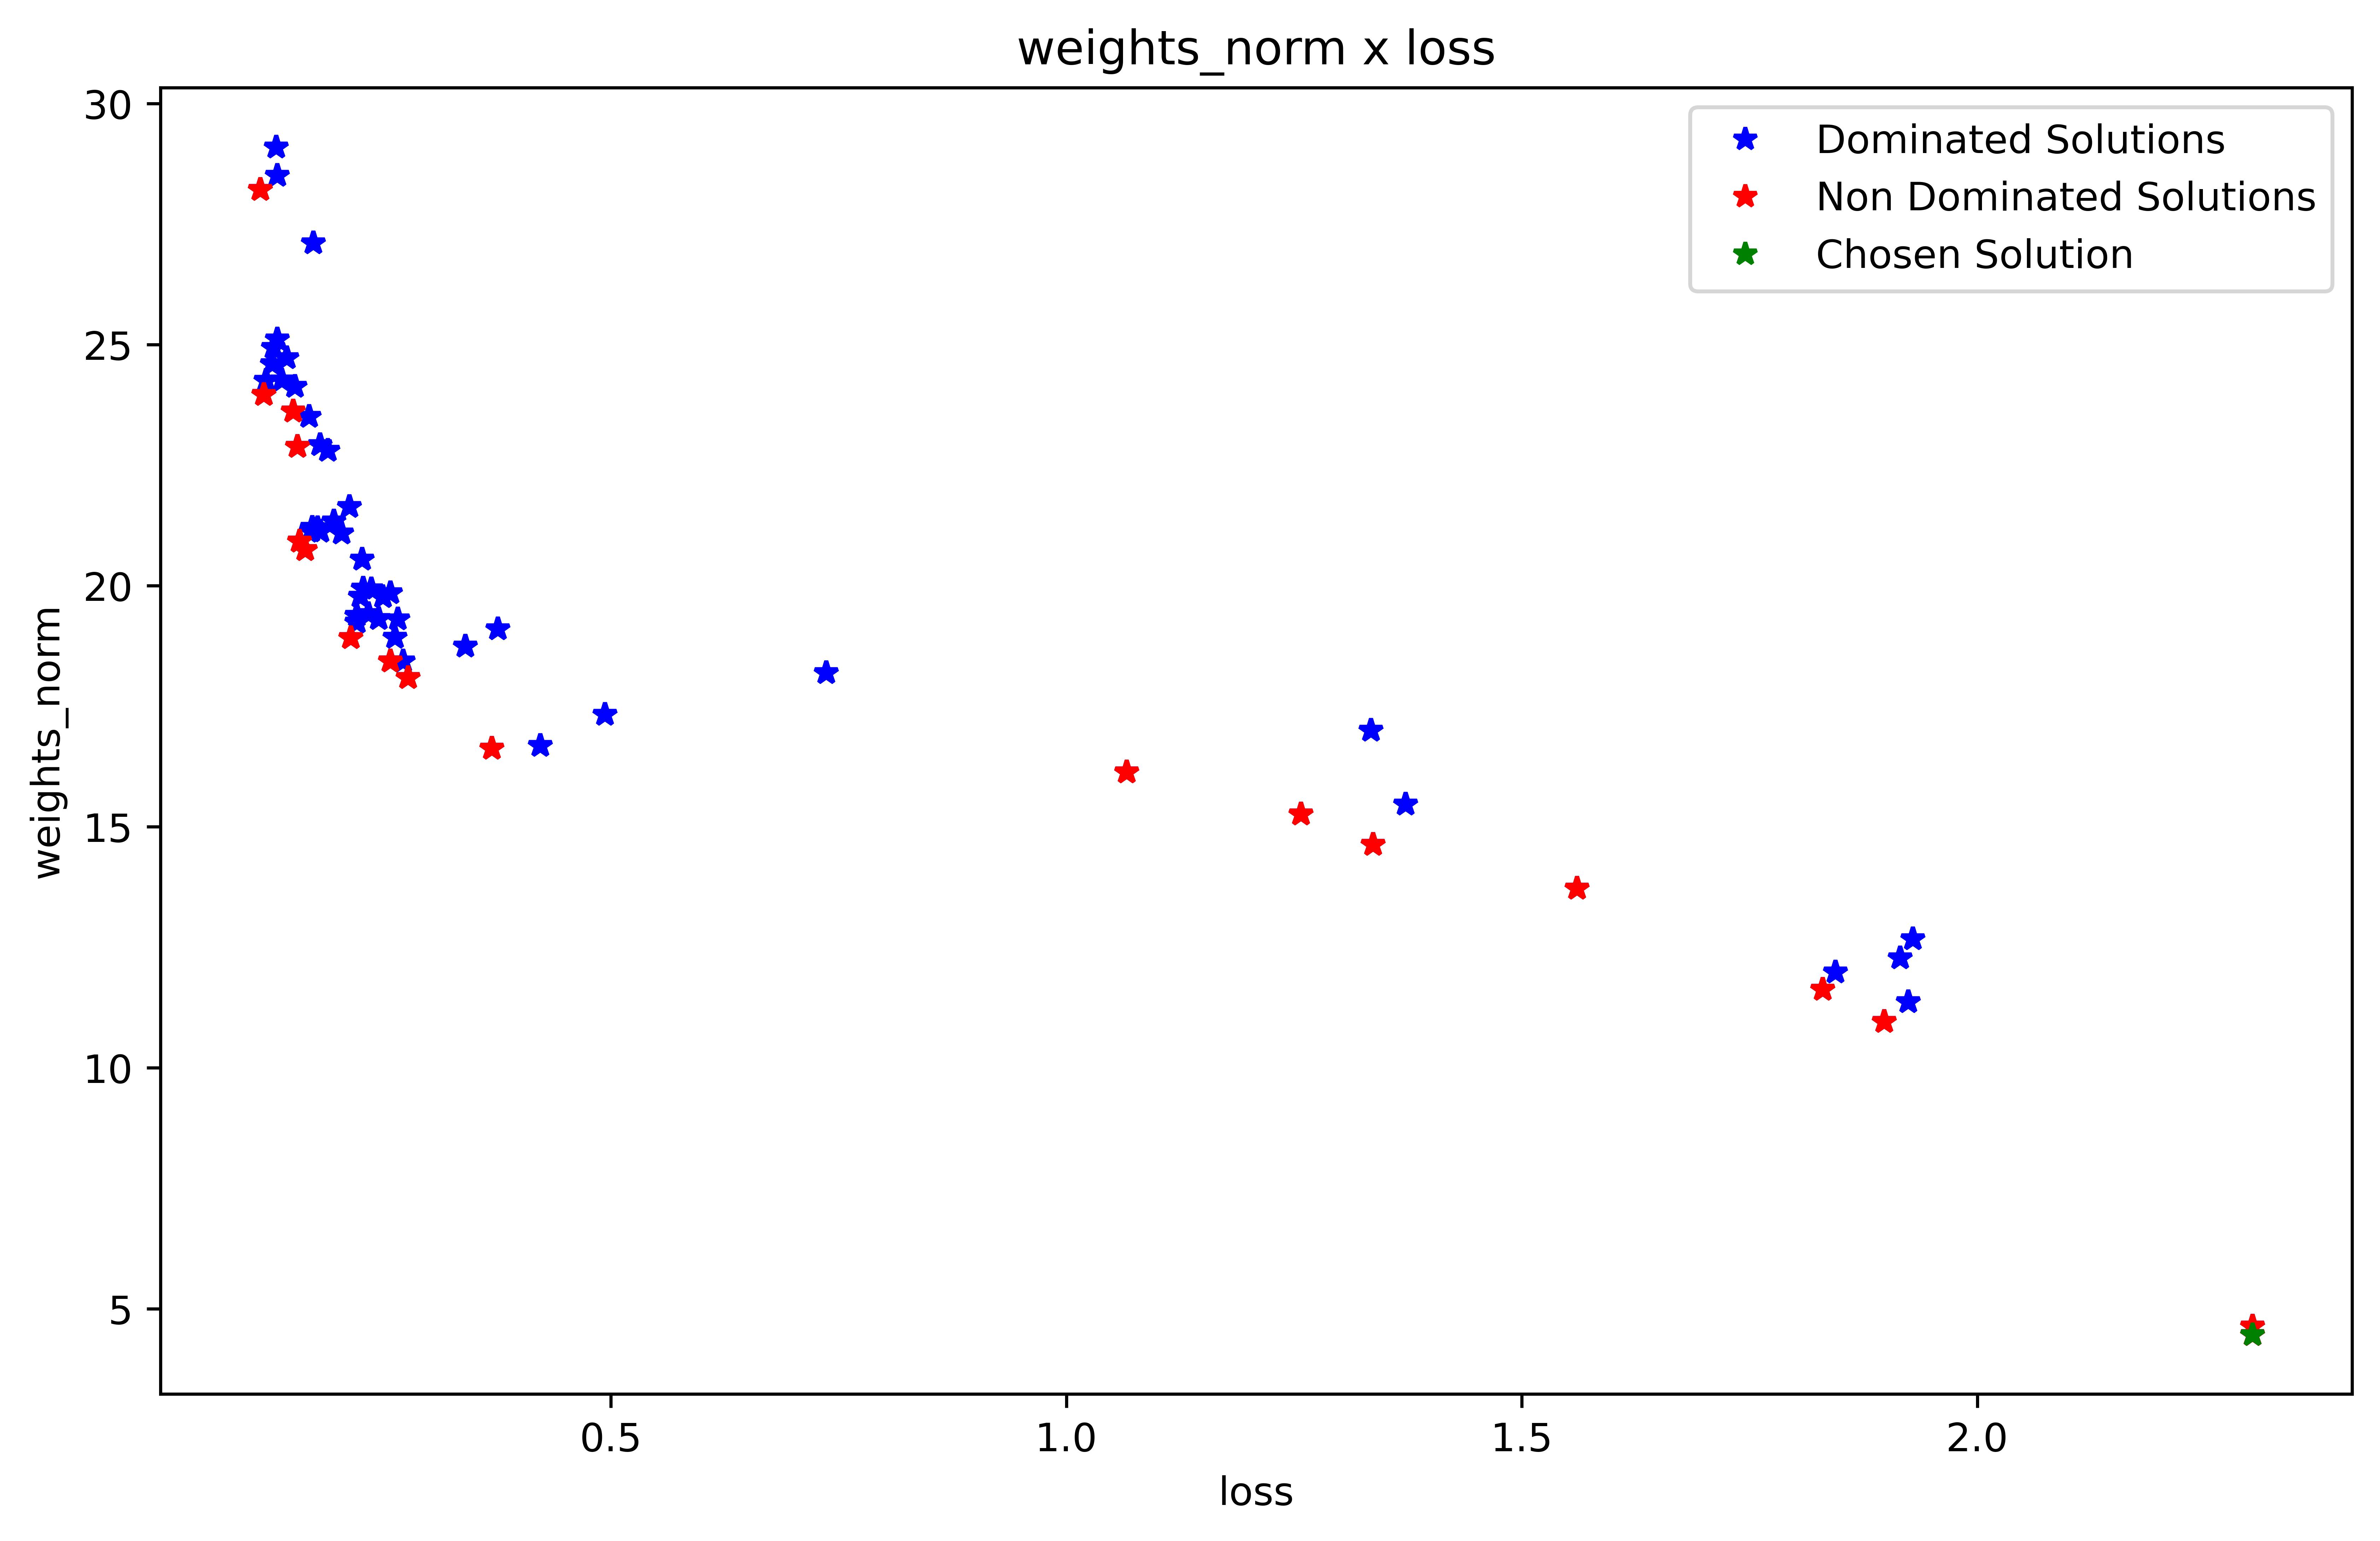

In [ ]:
ga3 = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "weights_norm", 0.30, "loss", 0.30)
result = ga3.solve(generations=10)

Generation 0


100%|██████████| 12/12 [12:49<00:00, 64.10s/it]


Best Solution -> G0:
accuracy: 0.95867
latency: 0.00025
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]
Generation 1


100%|██████████| 12/12 [11:23<00:00, 56.99s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 2


100%|██████████| 12/12 [24:32<00:00, 122.71s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 3


100%|██████████| 12/12 [29:32<00:00, 147.71s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 4


100%|██████████| 12/12 [17:59<00:00, 89.99s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 5


100%|██████████| 12/12 [37:16<00:00, 186.33s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 6


100%|██████████| 12/12 [22:34<00:00, 112.85s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 7


100%|██████████| 12/12 [28:22<00:00, 141.91s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 8


100%|██████████| 12/12 [16:24<00:00, 82.00s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 9


100%|██████████| 12/12 [22:47<00:00, 113.97s/it]


Best Solution -> G1:
accuracy: 0.965
latency: 0.00026
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
Generation 10


100%|██████████| 12/12 [19:48<00:00, 99.03s/it]


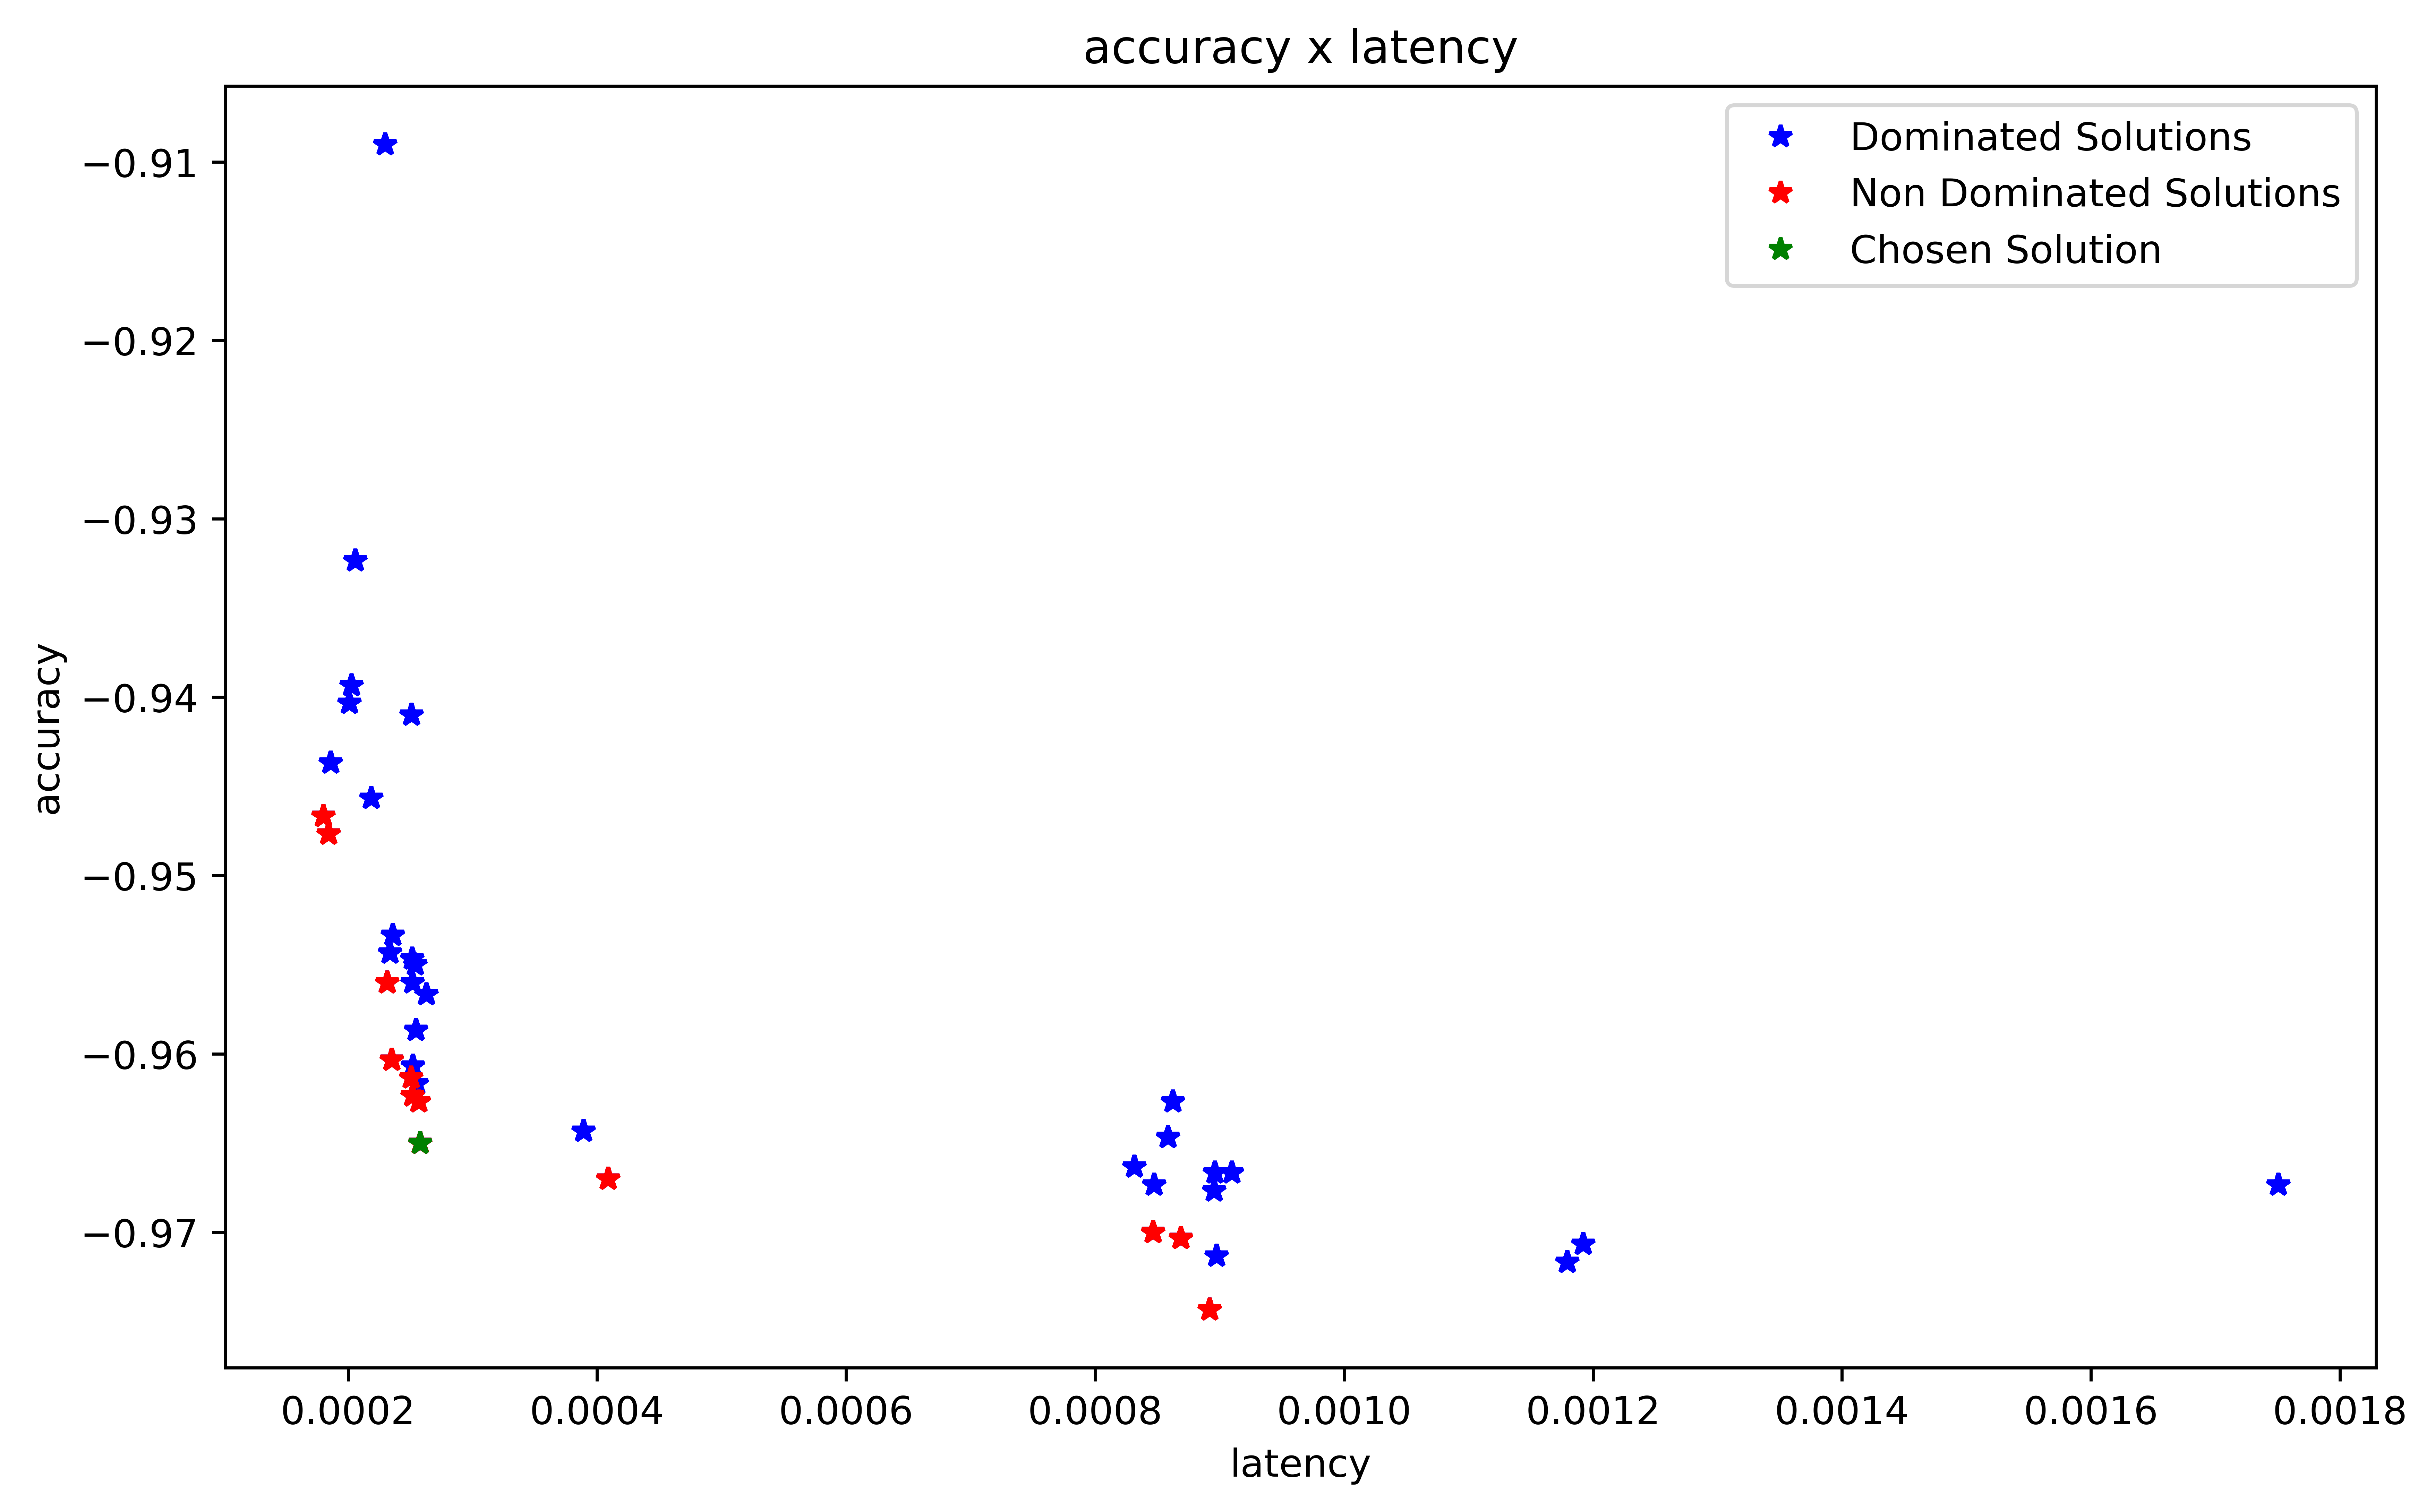

In [8]:
ga4 = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "accuracy", 0.02, "latency", 0.20)
result = ga4.solve(generations=10)

Generation 0


100%|██████████| 12/12 [07:14<00:00, 36.25s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 1


100%|██████████| 12/12 [05:15<00:00, 26.29s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 2


100%|██████████| 12/12 [05:54<00:00, 29.56s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 3


100%|██████████| 12/12 [06:00<00:00, 30.06s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 4


100%|██████████| 12/12 [13:03<00:00, 65.25s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 5


100%|██████████| 12/12 [07:23<00:00, 36.94s/it]


Best Solution -> G0:
loss: 0.13641
latency: 0.00017
Gene: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
Generation 6


100%|██████████| 12/12 [08:23<00:00, 41.96s/it]


Best Solution -> G2:
loss: 0.13057
latency: 0.00019
Gene: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
Generation 7


100%|██████████| 12/12 [06:05<00:00, 30.47s/it]


Best Solution -> G3:
loss: 0.12565
latency: 0.00019
Gene: [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Generation 8


100%|██████████| 12/12 [05:40<00:00, 28.36s/it]


Best Solution -> G1:
loss: 0.11879
latency: 0.00019
Gene: [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Generation 9


100%|██████████| 12/12 [05:56<00:00, 29.71s/it]


Best Solution -> G1:
loss: 0.11879
latency: 0.00019
Gene: [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Generation 10


100%|██████████| 12/12 [05:44<00:00, 28.68s/it]


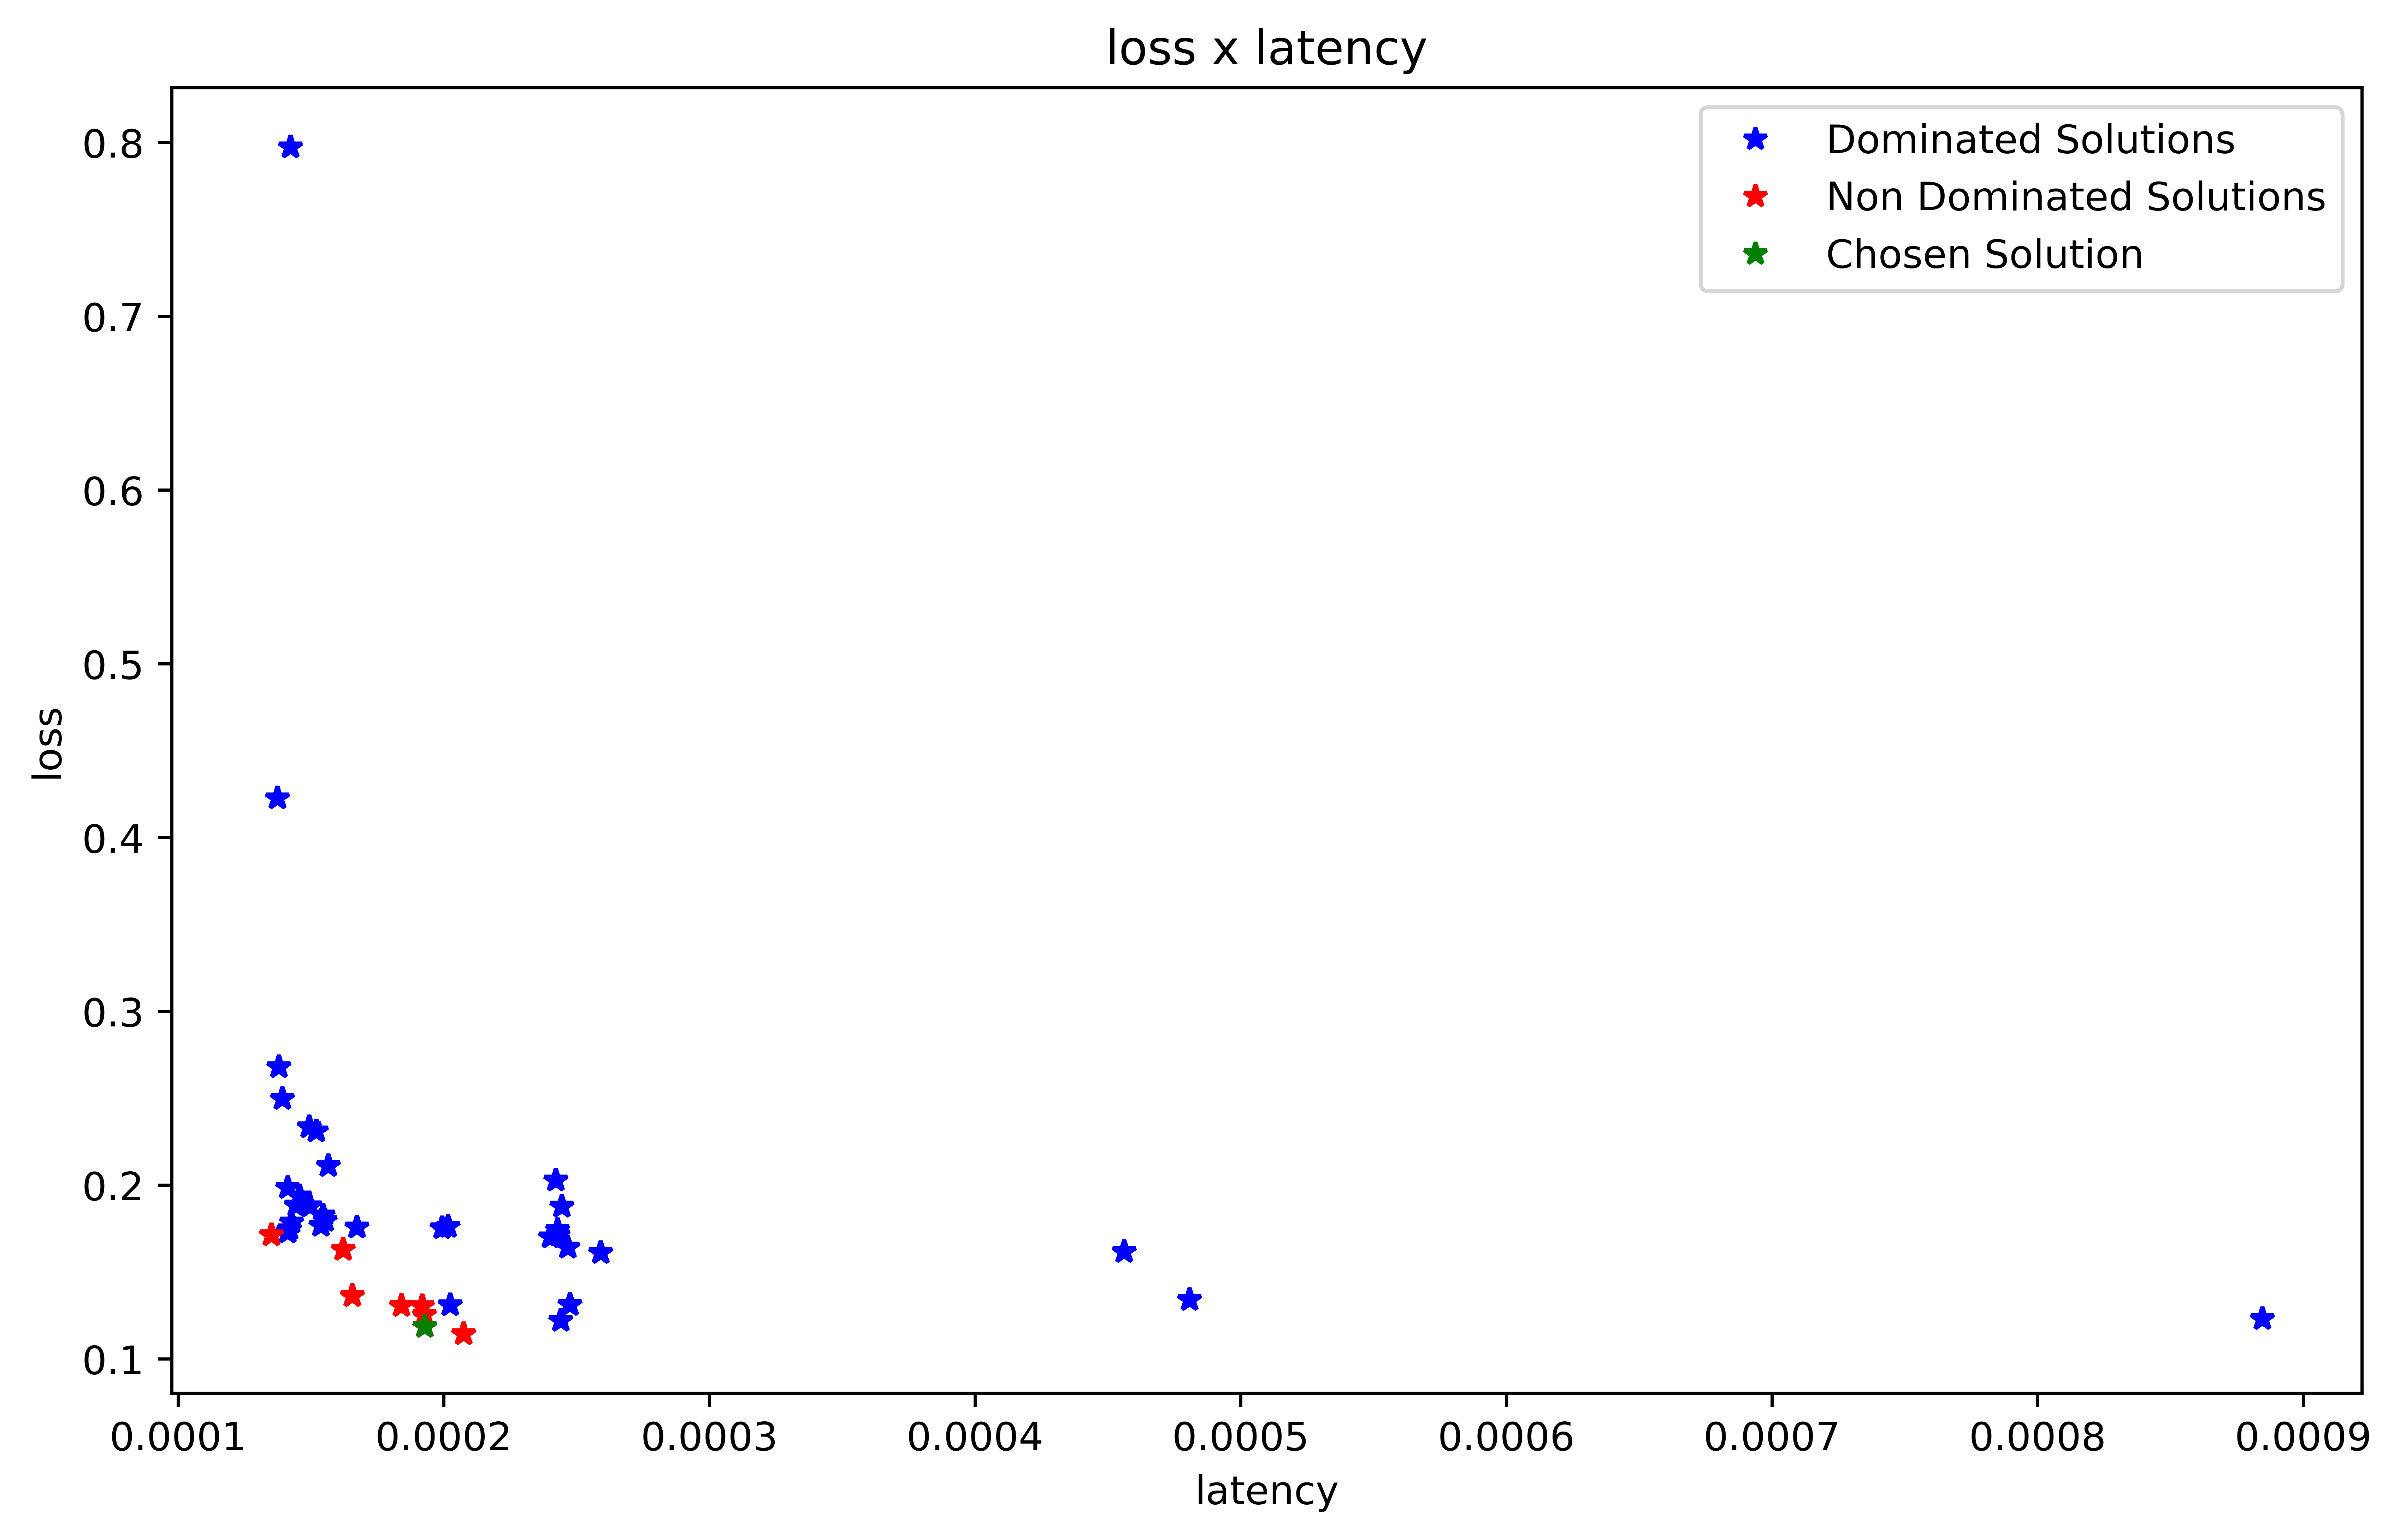

In [9]:
ga5 = GeneticAlgorithm(12, train_images, test_images, train_labels, test_labels, "loss", 0.20, "latency", 0.20)
result = ga5.solve(generations=10)